<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Spotify songs analysis with lyrics

Data contains almost **300.000** records, It was created by me, in the steps presented in **dataset-creator.jpynb**. Around **~32.000** rows have its own unique **Lyrics** scraped from **genius.com**. However every row contains features like:<br>

- **Song Name**
- **Release Date**
- **Album Popularity**
- **Artist Popularity**
- **Song Popularity**
- **Artist Genres**
- **Language of Lyrics**
- **Duration**
- **Whether it is a solo song or with someone**
- Other technical features f.ex. **Loudness**, **Danceability**, **Liveness**, ...


One of the main purposes of this analysis is to see how different technical features vary across different **genres**, **languages** and other factors.<br><br>
Next thing that would be nice is checking how the **dictionary of words changes with years** in songs across different genres, what are the **most common words** in genres across years, and maybe find some other interesting aspects.<br>

I would also like to **create an estimator**, that will be able distinguish the **genre** of the song or specify which genre is the closest to your writing style.<br>
<br>



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy as sp
from db_management.db import SongsDB
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("inferno")
database = SongsDB()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's load the data



In [7]:
data = database.get_data()

In [8]:
df_lyrics = data.copy()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Quick Data Insight

There is some missing data especially related with artists, need to check it out. However creating the dataset, I know that there is also quite of a **missing values in a form of empty strings**, this is also something I need to be aware of.


In [9]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296029 entries, 0 to 296028
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   song_title          296029 non-null  object 
 1   song_release_date   296029 non-null  object 
 2   featured            296029 non-null  int64  
 3   song_popularity     296029 non-null  int64  
 4   acousticness        295785 non-null  float64
 5   danceability        295785 non-null  float64
 6   energy              295785 non-null  float64
 7   instrumentalness    295785 non-null  float64
 8   liveness            295785 non-null  float64
 9   loudness            295785 non-null  float64
 10  speechiness         295785 non-null  float64
 11  tempo               295785 non-null  float64
 12  valence             295785 non-null  float64
 13  mode                295785 non-null  float64
 14  key                 295785 non-null  float64
 15  duration_ms         295785 non-nul

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Missing values investigation

Apart from NaN values, there are some empty string values in **lyrics** and **artist genre** columns. There are **696** records, where there is a lyrics, but there is not a specified genre. The rest of the existing lyrics (**31732**) will be used to train the classification model.<br><br>
In terms of **genre**, I also need to do a little bit of a cleaning, the values there are stored in strings separated with commas, so i need to map these values to one specific genre.


In [10]:
from assets.static.genre_map import genre_map

def map_genres(genres):
    """
    Maps the genres separated with commas to one distinct, most fitting genre, using dictionary with mapping rules (genre_map).
    Finds the most fitting one (the genre with the most number of fits).

    If there is no fit, returns NaN. (Depends on the genre_map)
    """
    if isinstance(genres, str):
        mapped_genres = dict()
        for genre in genres.split(', '):
            for key in genre_map:
                if key in genre:
                    mapped_genres[genre_map[key]] = mapped_genres.get(genre_map[key], 0) + 1
        try:
            return max(mapped_genres.items(), key=lambda x:x[-1])[0]
        except:
            pass
    return np.NaN
    

df_lyrics["genre"] = df_lyrics["artist_genres"].apply(map_genres)

In [11]:
no_lyrics = (df_lyrics["lyrics"] == "") | (df_lyrics["lyrics"].isna())
no_genres = (df_lyrics["artist_genres"] == "") | (df_lyrics["artist_genres"].isna())

print("Empty lyrics:", len(df_lyrics[no_lyrics]))
print("Empty artist genre:", len(df_lyrics[no_genres]))
print("Lyrics, but no genre:", len(df_lyrics[no_genres & ~no_lyrics]))
print("Distinct Lyrics:", len(df_lyrics[~no_lyrics & ~no_genres]["lyrics"].unique()))

df_lyrics.loc[no_genres, "artist_genres"] = np.NaN
df_lyrics.loc[no_lyrics, "lyrics"] = np.NaN

Empty lyrics: 258745
Empty artist genre: 58560
Lyrics, but no genre: 696
Distinct Lyrics: 31732


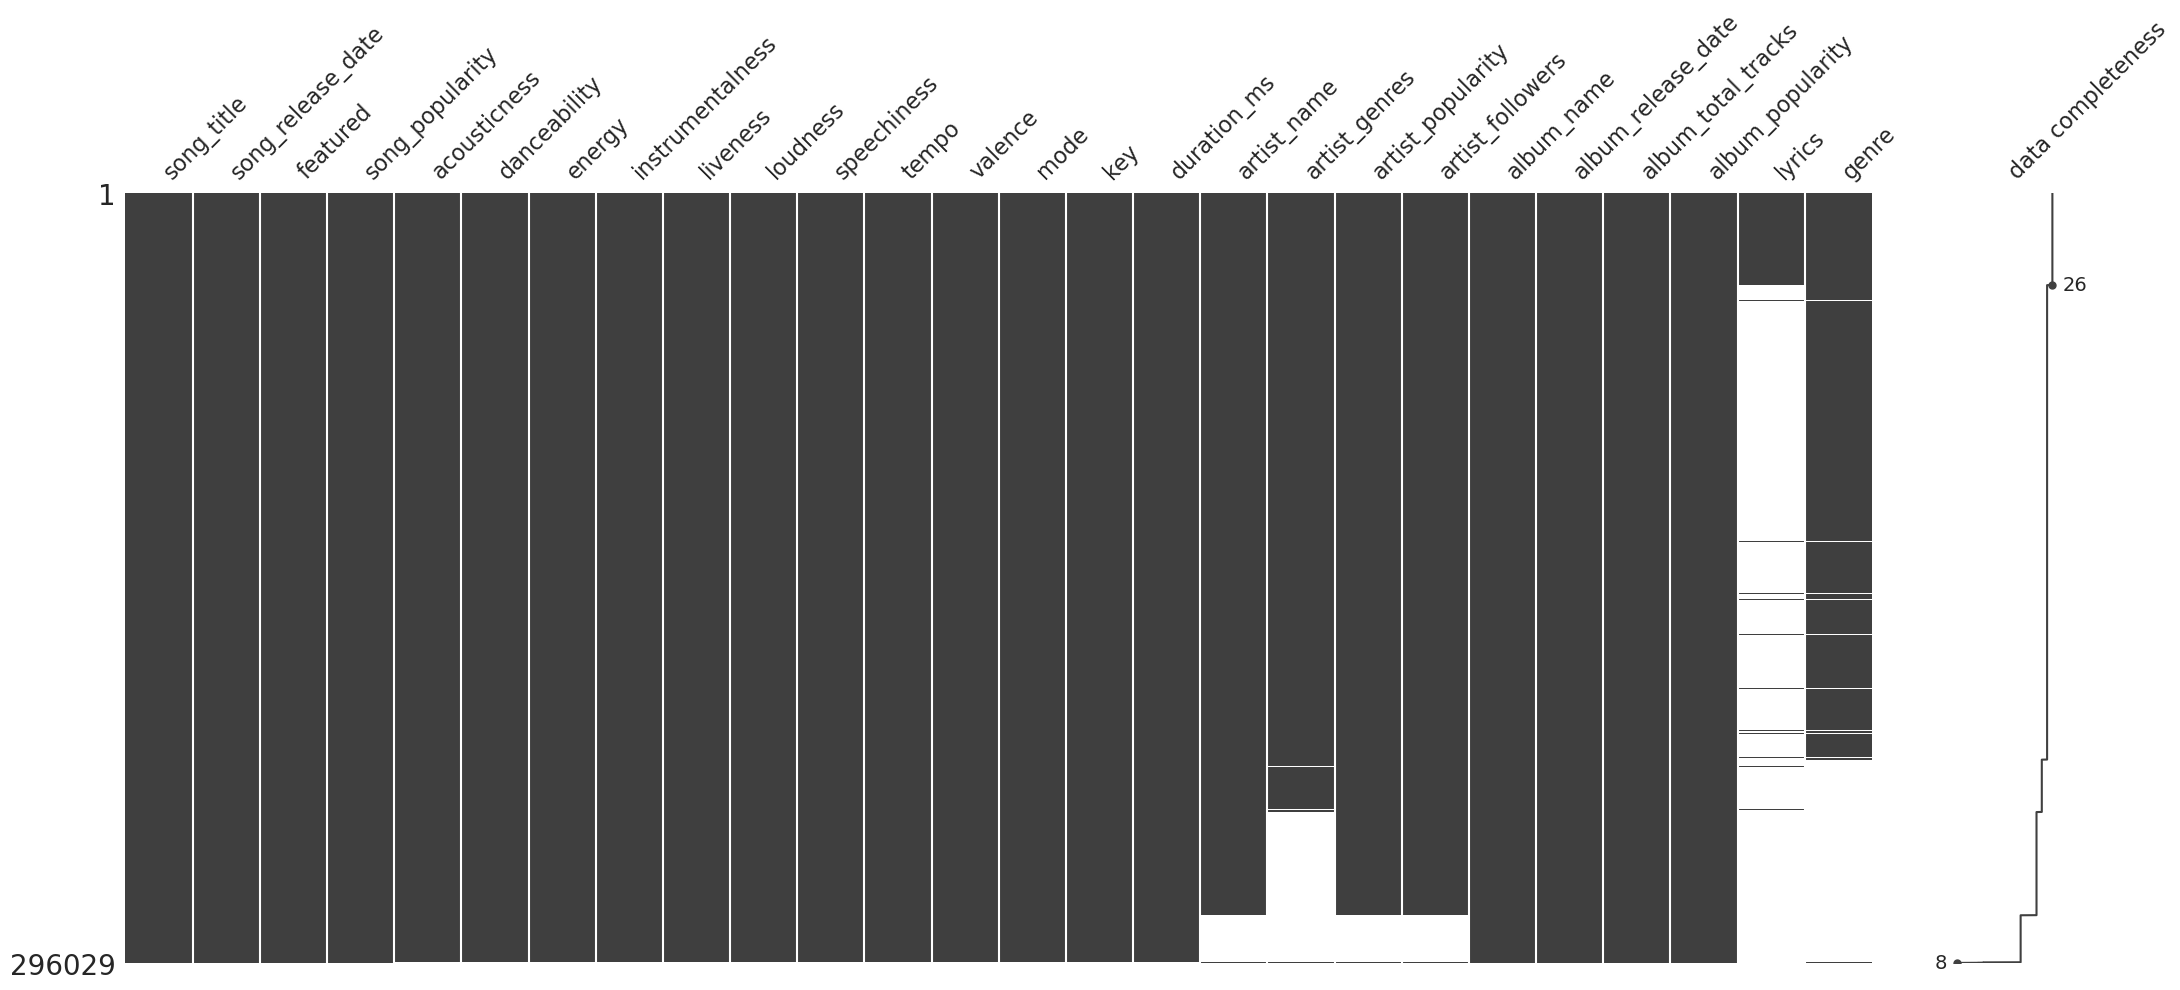

In [12]:
msno.matrix(df_lyrics, labels=True, sort="descending")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Two main objectives: Analysis and the Model

As these two have a little different requirements, I need to work on different parts of the data, first I will definitely drop the records where there is a **lack of the artist info**, especially the genre. After that I need to do a little bit of cleaning in terms of the:<br>

-**release_date**<br>
-**genres**<br><br>

I want to perform the analysis only on the songs with popularity >= 5, I don't want some random songs, especially knowing, that I extracted the lyrics only for the songs with popularity greater or equal to 40, So i won't lose any lyrics data.<br>

After dropping the missing values I am left with:<br>

-**178.000** records overall<br>
-**30.600** unique lyrics<br><br>

I found it crucial to drop these values, where the genre was not specified, because it is the most important aspect of the dataset.

In [13]:
df_lyrics = df_lyrics[df_lyrics["song_popularity"] >= 5]

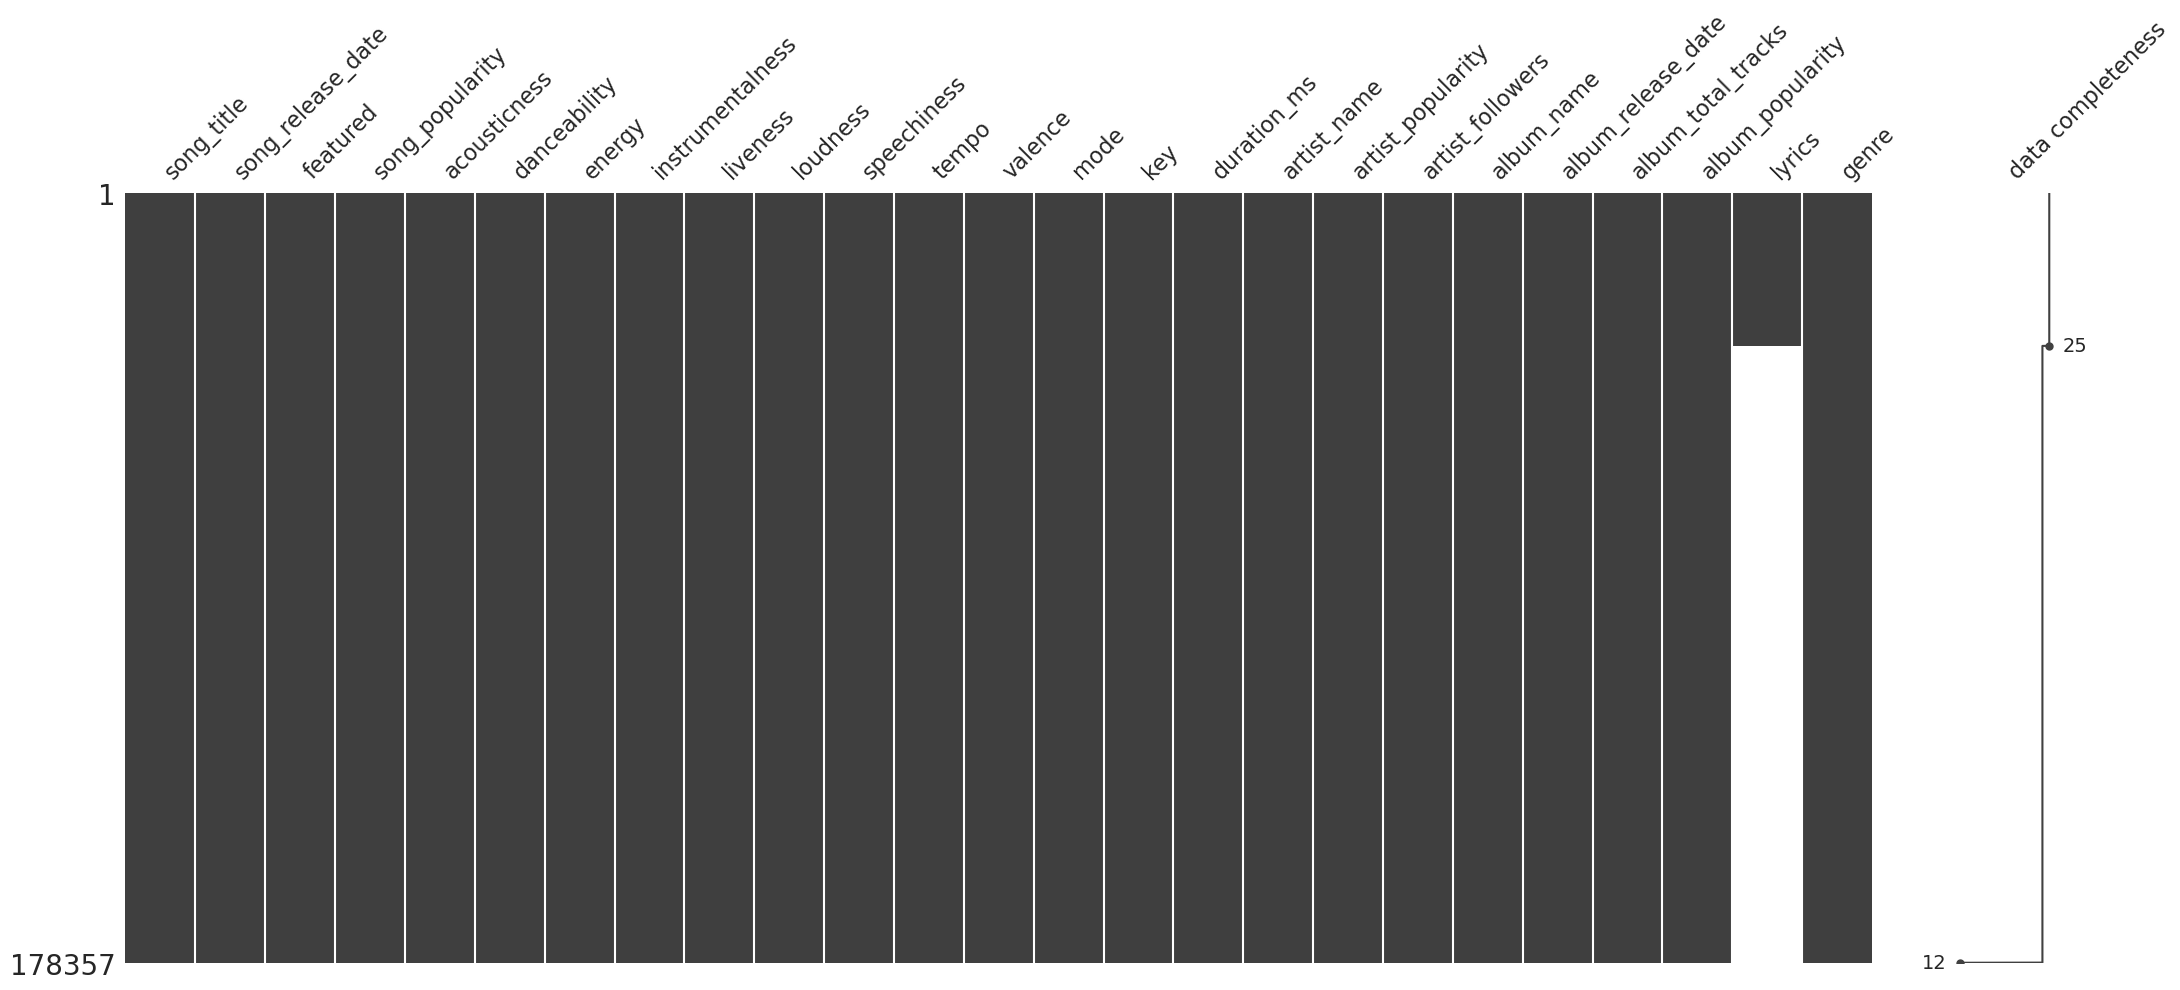

In [14]:
del df_lyrics["artist_genres"]
df_lyrics = df_lyrics.dropna(subset=["genre"])
msno.matrix(df_lyrics, labels=True, sort="descending")
plt.show()

In [15]:
len(df_lyrics["lyrics"].unique())

30683

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### There is no difference between album and song release date
So I need to drop it.

In [16]:
print("Song Release Date != Album Release Date:", len(df_lyrics[df_lyrics["song_release_date"] != df_lyrics["album_release_date"]]))
del df_lyrics["album_release_date"]

Song Release Date != Album Release Date: 0


<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Release date - feature extraction

I am going to extract the **Week day** and **Release Year** from release_date, only if it is possible!

In [17]:
dictionary = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

day_of_week = lambda date, dictionary: dictionary[datetime.strptime(date, "%Y-%m-%d").weekday()]

exact_date_precision = df_lyrics["song_release_date"].str.len() == 10

df_lyrics.loc[exact_date_precision, "day_of_week"] = df_lyrics.loc[exact_date_precision, "song_release_date"].apply(lambda x: day_of_week(x, dictionary))
df_lyrics["release_year"] = df_lyrics["song_release_date"].str[:4]

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Let's change duration's metric to seconds

In [18]:
df_lyrics["duration"] = df_lyrics["duration_ms"] // 1000
del df_lyrics["duration_ms"]

In [19]:
df_lyrics.head(3)

song_title song_release_date  featured  \
1  It's All Over Now - Mono Version        1964-10-17         0   
3                         It's Over              1962         0   
4                            Ramona        2015-05-07         0   

   song_popularity  acousticness  danceability  energy  instrumentalness  \
1               47        0.0235         0.603   0.689          0.000003   
3               44        0.7400         0.462   0.319          0.000758   
4               18        0.4800         0.679   0.422          0.000031   

   liveness  loudness  ...  artist_popularity  artist_followers  \
1    0.3300   -10.729  ...               79.0        14083807.0   
3    0.0803   -12.448  ...               68.0         2024651.0   
4    0.1540   -10.860  ...               37.0           39741.0   

         album_name  album_total_tracks  album_popularity  \
1            12 X 5                  12                45   
3  Oh, Pretty Woman                  12                71   
4    The Collection                  25                30   

                                              lyrics  genre  day_of_week  \
1   Well, baby used to stay out all night long Sh...   rock     Saturday   
3   Your baby doesn't love you anymore  Golden da...   folk          NaN   
4                                                NaN   rock     Thursday   

  release_year  duration  
1         1964     206.0  
3         1962     181.0  
4         2015     160.0  

[3 rows x 26 columns]

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

## Let's see what is the nature of each numerical feature



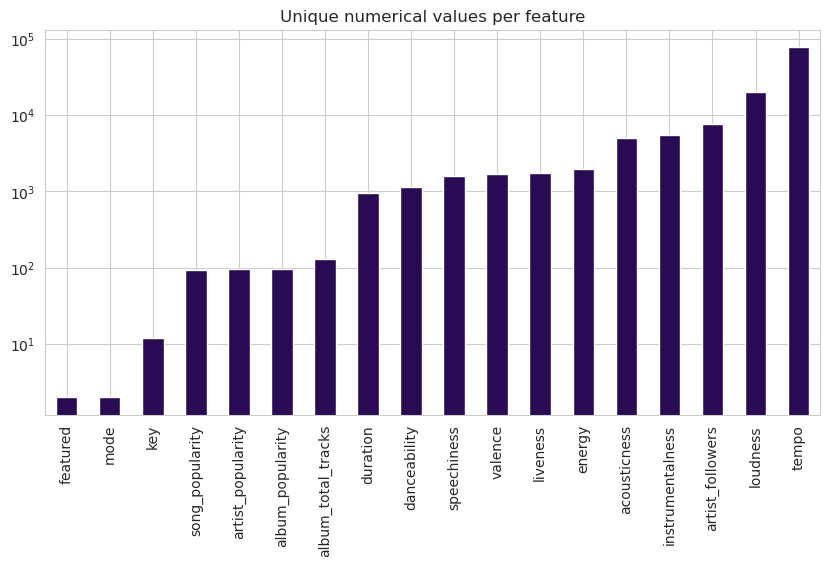

In [20]:
unique_values = df_lyrics.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(figsize=(10,5), title="Unique numerical values per feature", logy=True)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

## And now the categorical features



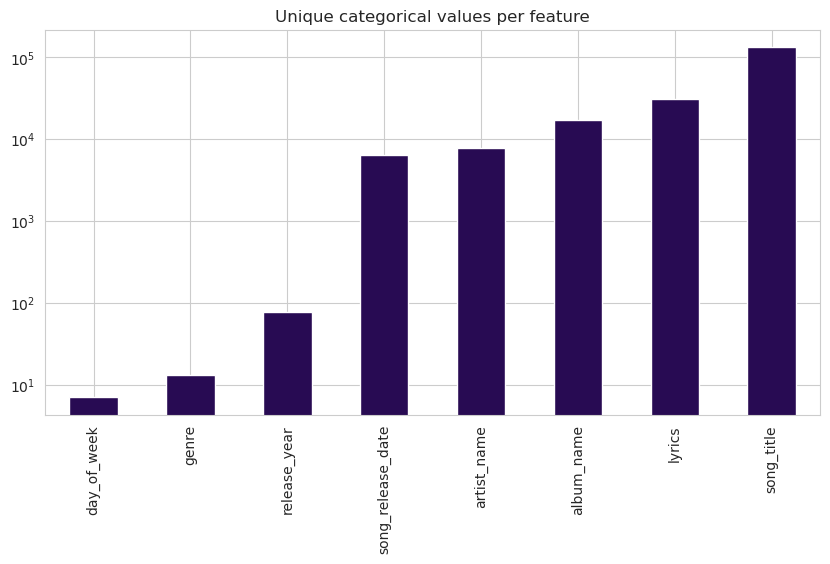

In [21]:
unique_values = df_lyrics.select_dtypes(exclude="number").nunique().sort_values()
unique_values.plot.bar(figsize=(10,5), title="Unique categorical values per feature", logy=True)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

## The amount of each genre in dataset

The dataset is **not too balanced** and the map is obviously not perfect, we can see the dominance of **rock, pop, electronical, rap and r&b** genres.
There are a few genres with just a little of the occurences, I need to group them even more tightly into more general groups.



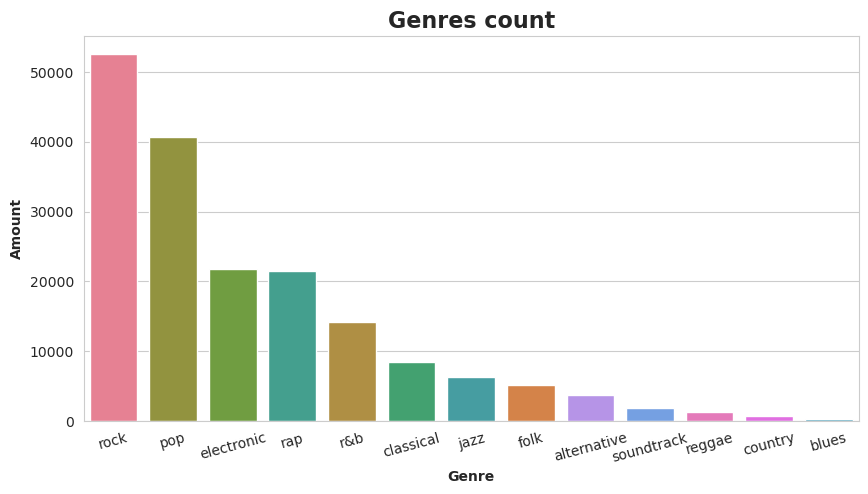

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_lyrics, x="genre", hue="genre",
              order=df_lyrics["genre"].value_counts().index)

plt.title("Genres count", weight="bold", fontsize=16)
plt.xlabel("Genre", weight="bold")
plt.ylabel("Amount", weight="bold")
plt.xticks(rotation=15)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Now let's see how this looks like across years

I want to see whether the data is balanced across years in terms of genres of the records.

It doesn't look the worst.



In [23]:
df_lyrics["release_year"] = df_lyrics["release_year"].astype(int)

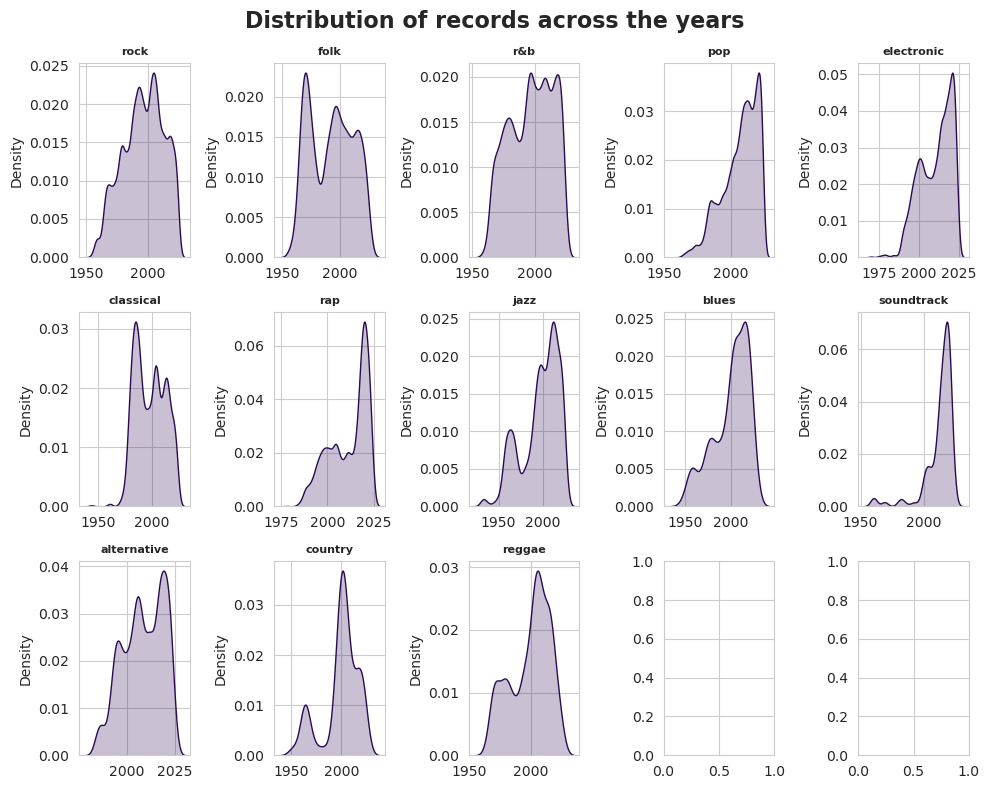

In [24]:
fig, axes = plt.subplots(figsize=(10,8), nrows=3, ncols=5)

for ax, genre in zip(axes.flatten(), df_lyrics["genre"].unique()):
    dat = df_lyrics[df_lyrics["genre"] == genre]
    sns.kdeplot(data=dat, x="release_year", fill=True, ax=ax)
    ax.set_title(genre, weight="bold", fontsize=8)
    ax.set_xlabel("")
fig.suptitle("Distribution of records across the years", weight="bold", fontsize=16)
    
plt.tight_layout()
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's have a grasp of how data looks like

Now we can see, that we have one **binary** (mode), and one **ordinary** (key) feature.<br> The rest is numerical, and vary in their values.<br><br>
We can also see a little pattern existing due to the way of data collection methods.



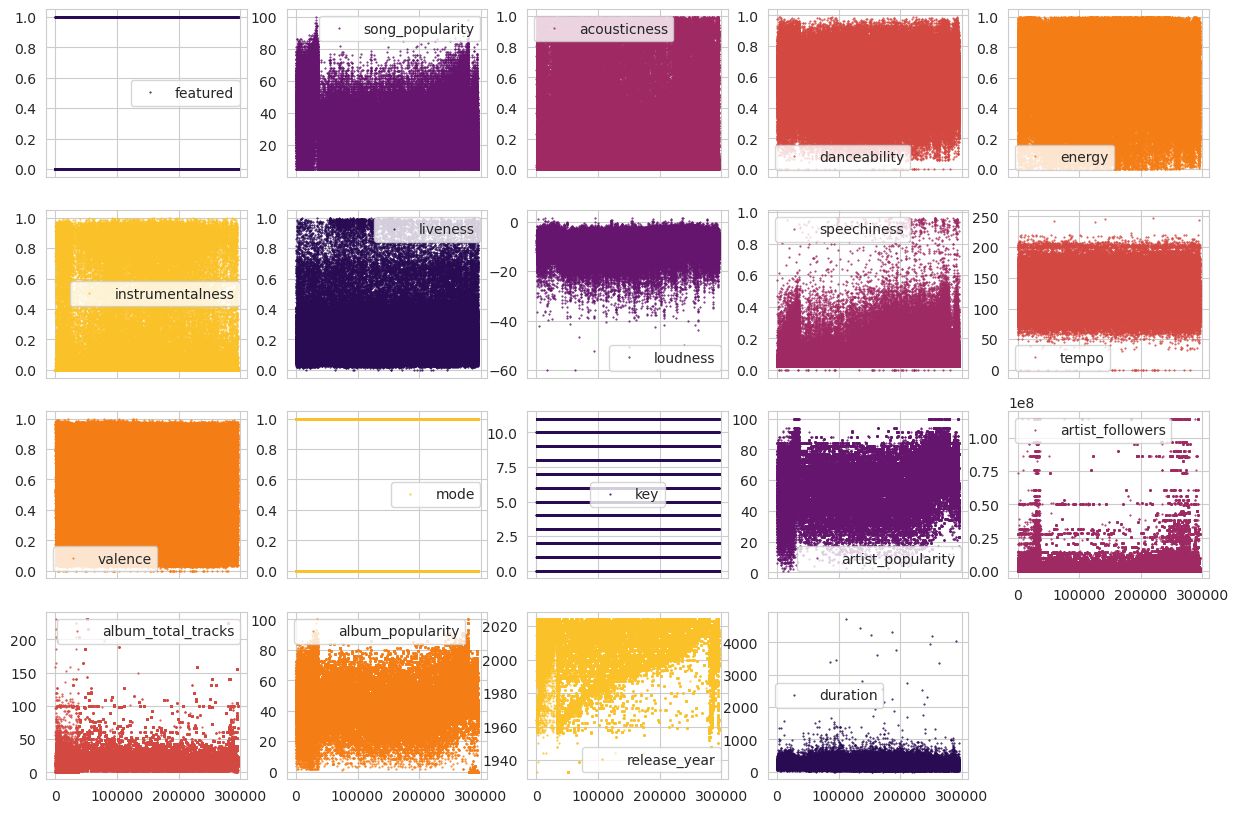

In [25]:
df_lyrics.plot(lw=0, marker=".", subplots=True, layout=(-1,5), figsize=(15,10), markersize=1)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Most frequent artists in dataset

Wooah! There is almost **1200 Elvis songs** in the dataset!<br>
That's almost 2x more than the second position - **Glee Cast**. I didn't know what the Glee Cast was, until I googled it, and found out it is some sort of **TV Show**.
<br><br>
To be honest, I find it a little bit **suspicious**.
<br>
Let's look at the duplicates then!



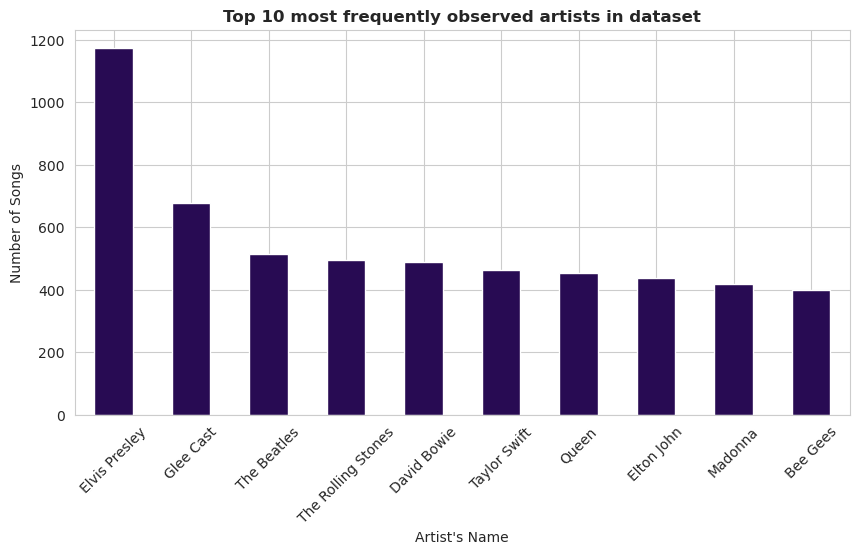

In [26]:
most_frequent_artists = df_lyrics["artist_name"].value_counts().sort_values(ascending=False).head(10)
most_frequent_artists.plot(kind="bar", figsize=(10, 5))
plt.title("Top 10 most frequently observed artists in dataset", weight="bold")
plt.xlabel("Artist's Name")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()


<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's see the duplicates

Yeah, as I supposed - Around **3400 of duplicated entries**, including **Elvis, Madonna and Taylor** from the previous graph.
<br>
Let's get rid of them and continue the analysis.



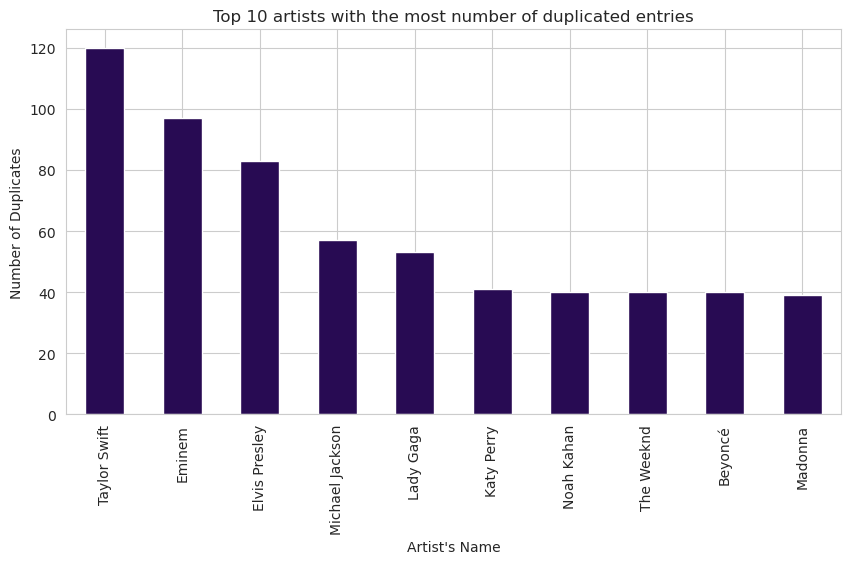

In [27]:
no_duplicates = df_lyrics.drop_duplicates(subset=["song_title", "artist_name"])

duplicates = df_lyrics[~df_lyrics.isin(no_duplicates)].dropna()

duplicates["artist_name"].value_counts().sort_values(ascending=False).head(10).plot(kind="bar", figsize=(10,5))
plt.title("Top 10 artists with the most number of duplicated entries")
plt.xlabel("Artist's Name")
plt.ylabel("Number of Duplicates")
plt.show()

In [28]:
duplicates.shape[0]

3441

In [29]:
len(no_duplicates["lyrics"].unique())

29851

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's look at the feature distribution

Ok, so **first insights from the distrubutions:**

- **Strong right skewness** in terms of **speechiness, acousticness, instrumentalness** makes these features inbalanced in this dataset, presenting the songs mostly as the opposites of these metrics.

- Similiar situation is found in **liveness**, however the effect is not as strong as in the previously mentioned features.

- The overall **release_year** distribution looks linear, having mostly the new songs, but it is not that bad to be honest.

- In terms of duration, number of total tracks in the album and the number of artist's followers, it does not really matter here.


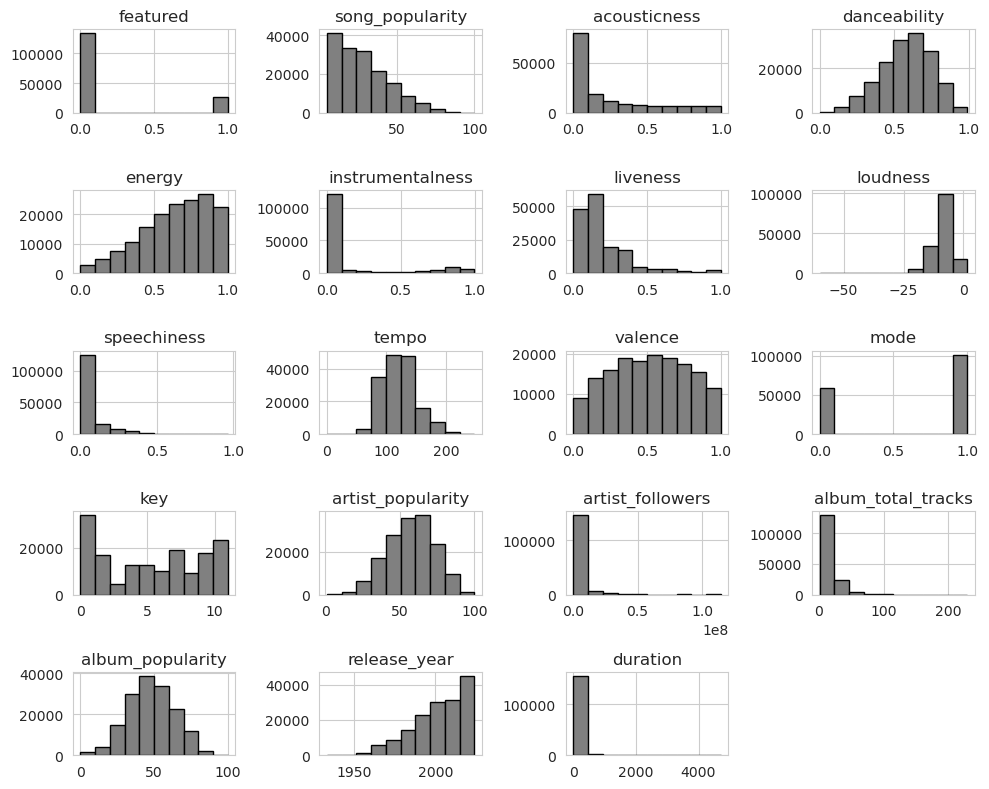

In [30]:
no_duplicates.hist(figsize=(10,8), layout=(-1,4), edgecolor="black", color="gray", bins=10)
plt.tight_layout()
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Ok, let's see the relations between every feature

The **hexbin** will help to locate where the most of the data is located in the scatterplots.


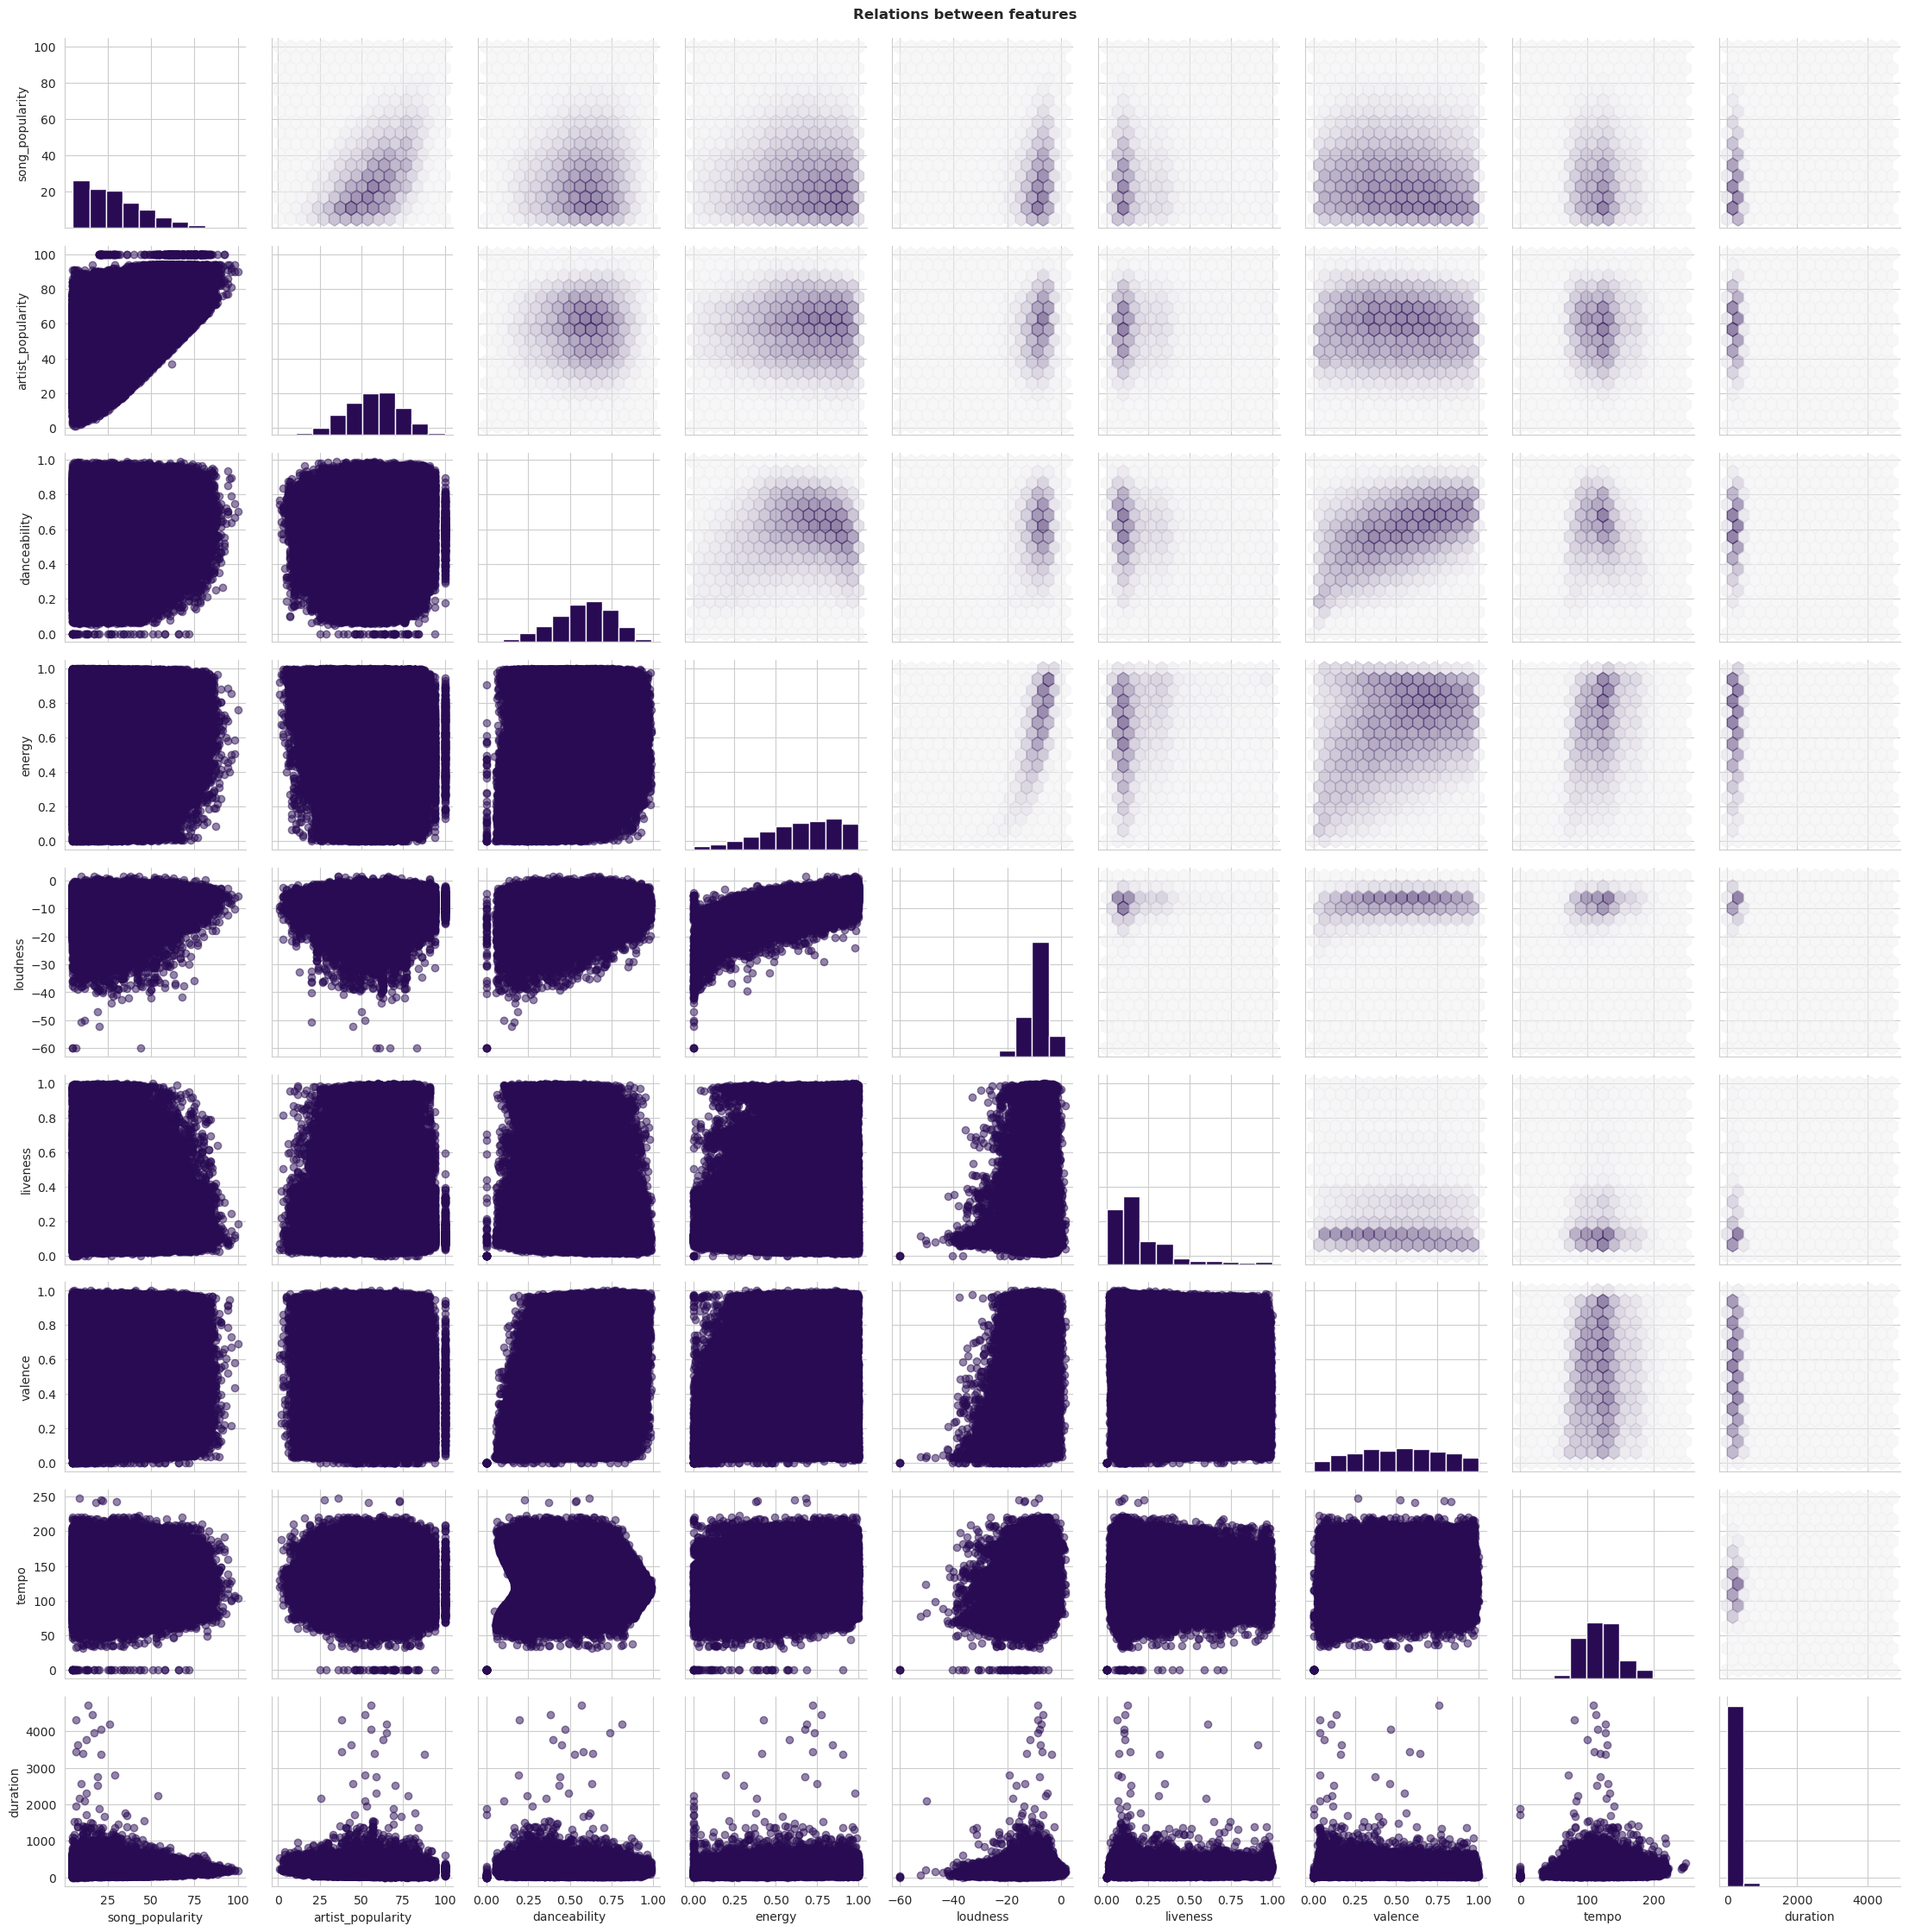

In [31]:
numerical_features = no_duplicates.select_dtypes(include="number").nunique() > 12
data_continous = no_duplicates[numerical_features[numerical_features].index]

def hex_pairplot(data, vars=None):

    def hexbin(x, y, color, max_series=None, min_series=None, **kwargs):
        cmap = sns.light_palette(color, as_cmap=True)
        ax = plt.gca()
        xmin, xmax = min_series[x.name], max_series[x.name]
        ymin, ymax = min_series[y.name], max_series[y.name]
        plt.hexbin(x, y, gridsize=15, cmap=cmap, extent=[xmin, xmax, ymin, ymax], **kwargs)
    if vars:
        g = sns.PairGrid(data[vars])
    else:
        g = sns.PairGrid(data)
    g.map_diag(plt.hist)
    g.map_lower(plt.scatter, alpha=0.5)
    g.map_upper(hexbin, min_series=data.min(), max_series=data.max(), alpha=0.5)

    return g

# excluding the strongly skewed features
g = hex_pairplot(data_continous, vars=["song_popularity", "artist_popularity", "danceability", "energy", "loudness", "liveness", "valence", "tempo", "duration"])
g.fig.suptitle("Relations between features", y=1, weight="bold")
plt.show()

In [32]:
corr = no_duplicates.select_dtypes(include="number").corr()

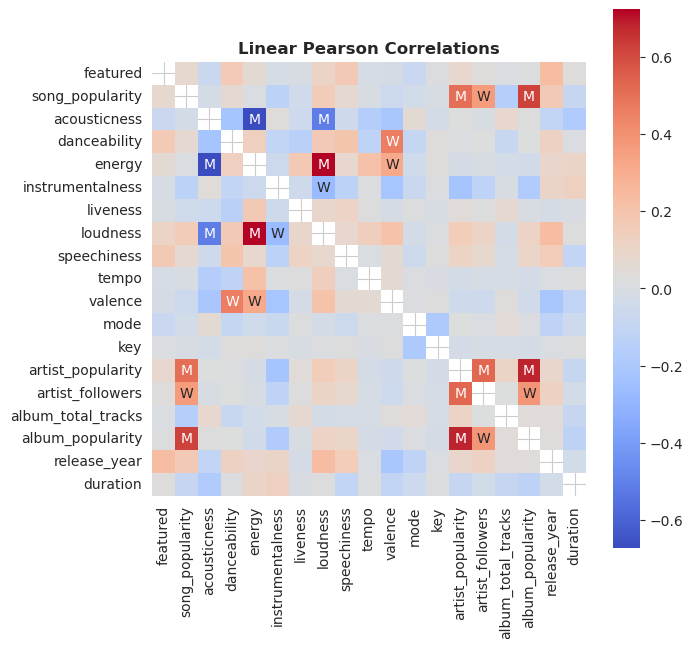

In [33]:
labels = np.where(np.abs(corr)>0.75, "S",
                  np.where(np.abs(corr)>0.5, "M",
                           np.where(np.abs(corr)>0.25, "W", "")))

plt.figure(figsize=(7,7))
sns.heatmap(corr, mask=np.eye(len(corr)),
            square=True, annot=labels, fmt='',
            cmap="coolwarm")
plt.title("Linear Pearson Correlations", weight="bold")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# How different features changed over time

Looking at the songs after 1969, there are a few interesting things to be investigated:<br>

-**Recent decreasing average duration**<br>

-**Decreasing loudness**<br>

-**Decreasing valence**<br>

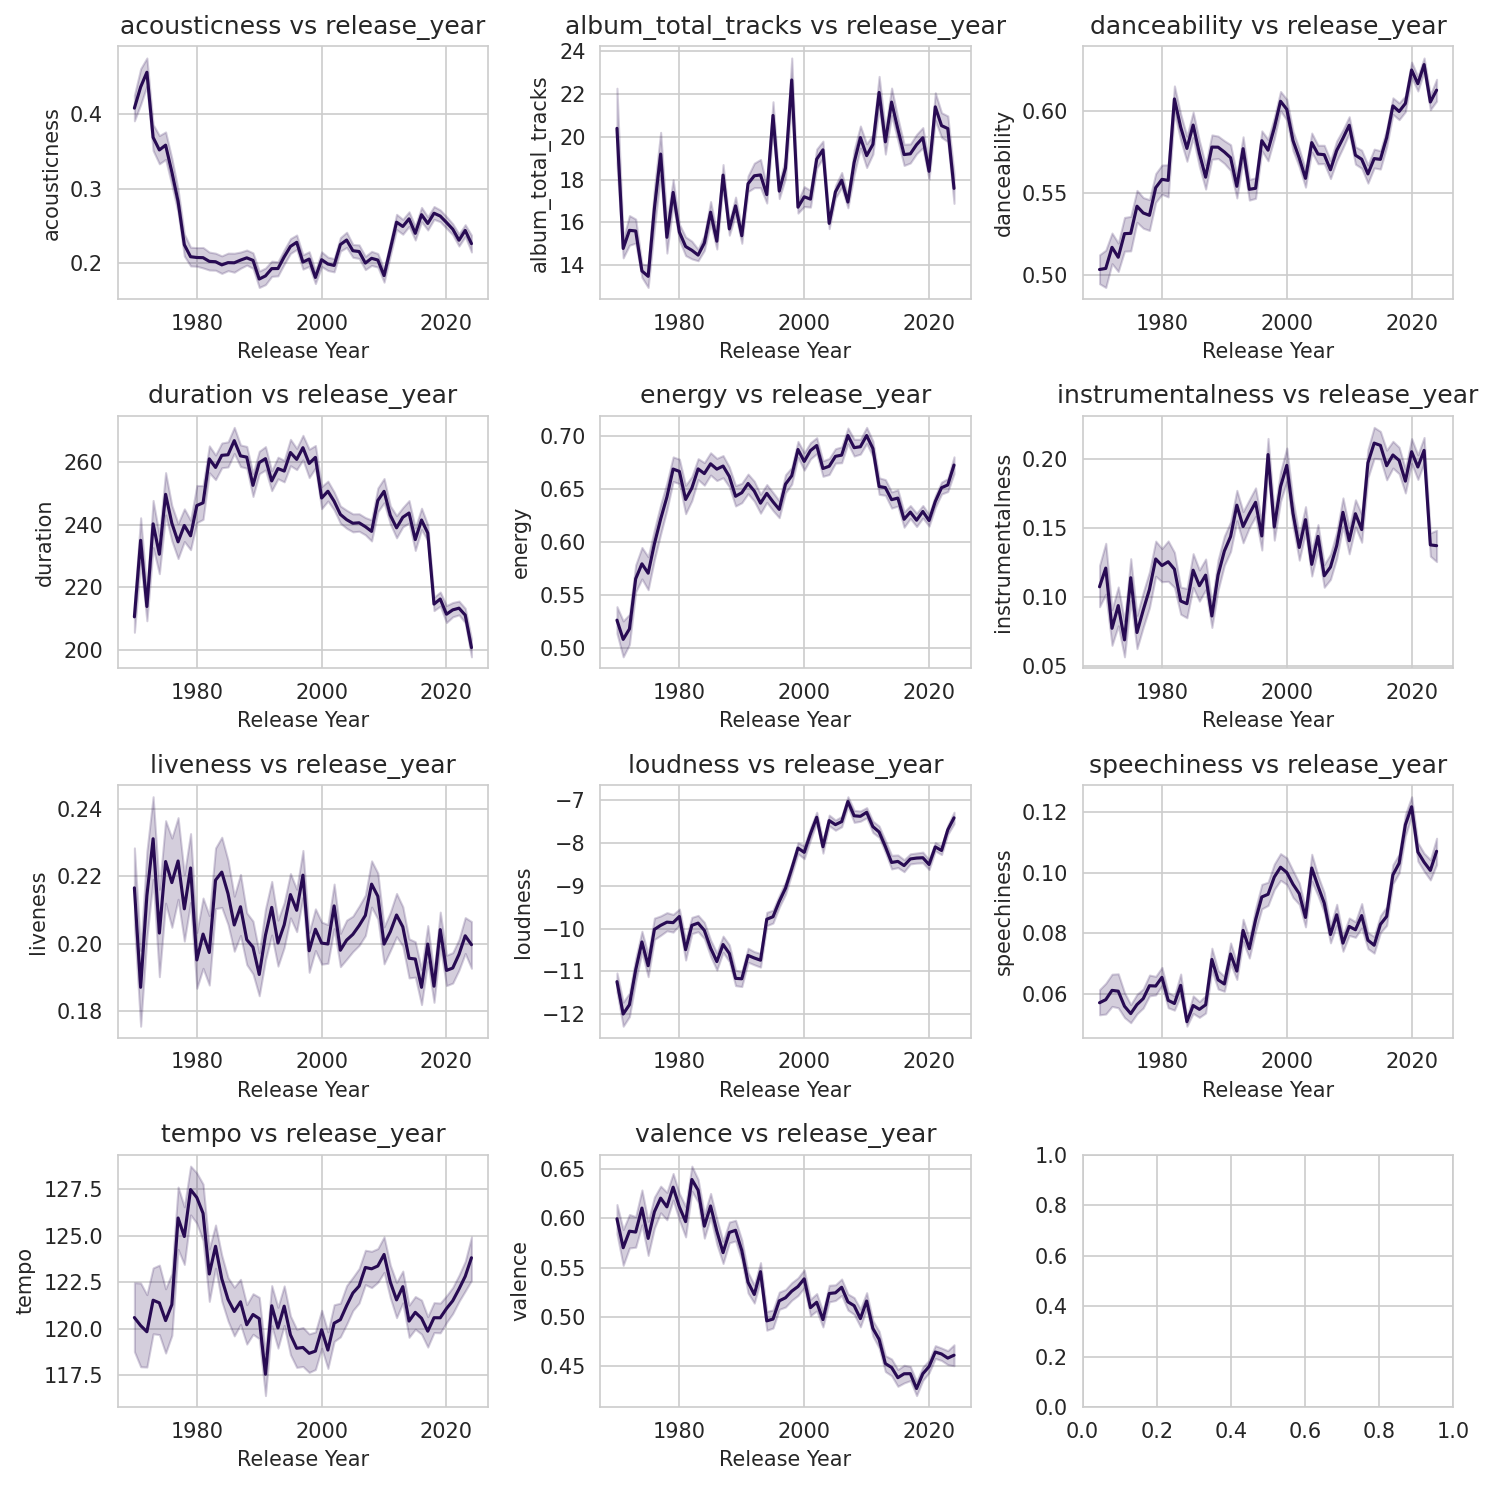

In [34]:
columns = no_duplicates.select_dtypes("number").columns.difference(['release_year', 'key', 'mode', 'featured', 'song_popularity', 'album_popularity', 'artist_followers', 'artist_popularity'])
fig, axes = plt.subplots(figsize=(10,10), nrows=4, ncols=3, dpi=150)

df_1970 = no_duplicates[no_duplicates["release_year"] >= 1970]


for ax, col in zip(axes.flatten(), columns):
    sns.lineplot(data=df_1970, x='release_year', y=col, ax=ax)
    ax.set_title(f'{col} vs release_year')
    ax.set_xlabel('Release Year')
    ax.set_ylabel(col)
plt.tight_layout()
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Songs duration across years and genres

---

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### First let's look at the overall duration across genres

I am going to skip the outliers here for a while.<br><br>

Look's like the longest songs are **electronic**, and on average **soundtracks** are the shortest.

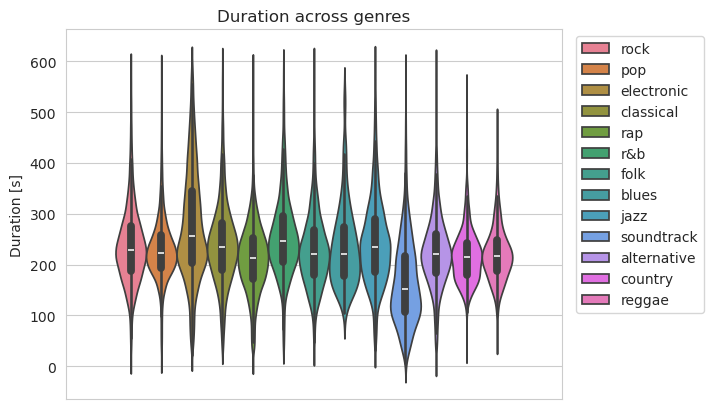

In [35]:
sns.violinplot(data=df_1970[df_1970["duration"] < 600], y="duration", hue="genre")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title("Duration across genres")
plt.ylabel("Duration [s]")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Duration behaviour over years

There is only one obvious decrease in **rap** genre.

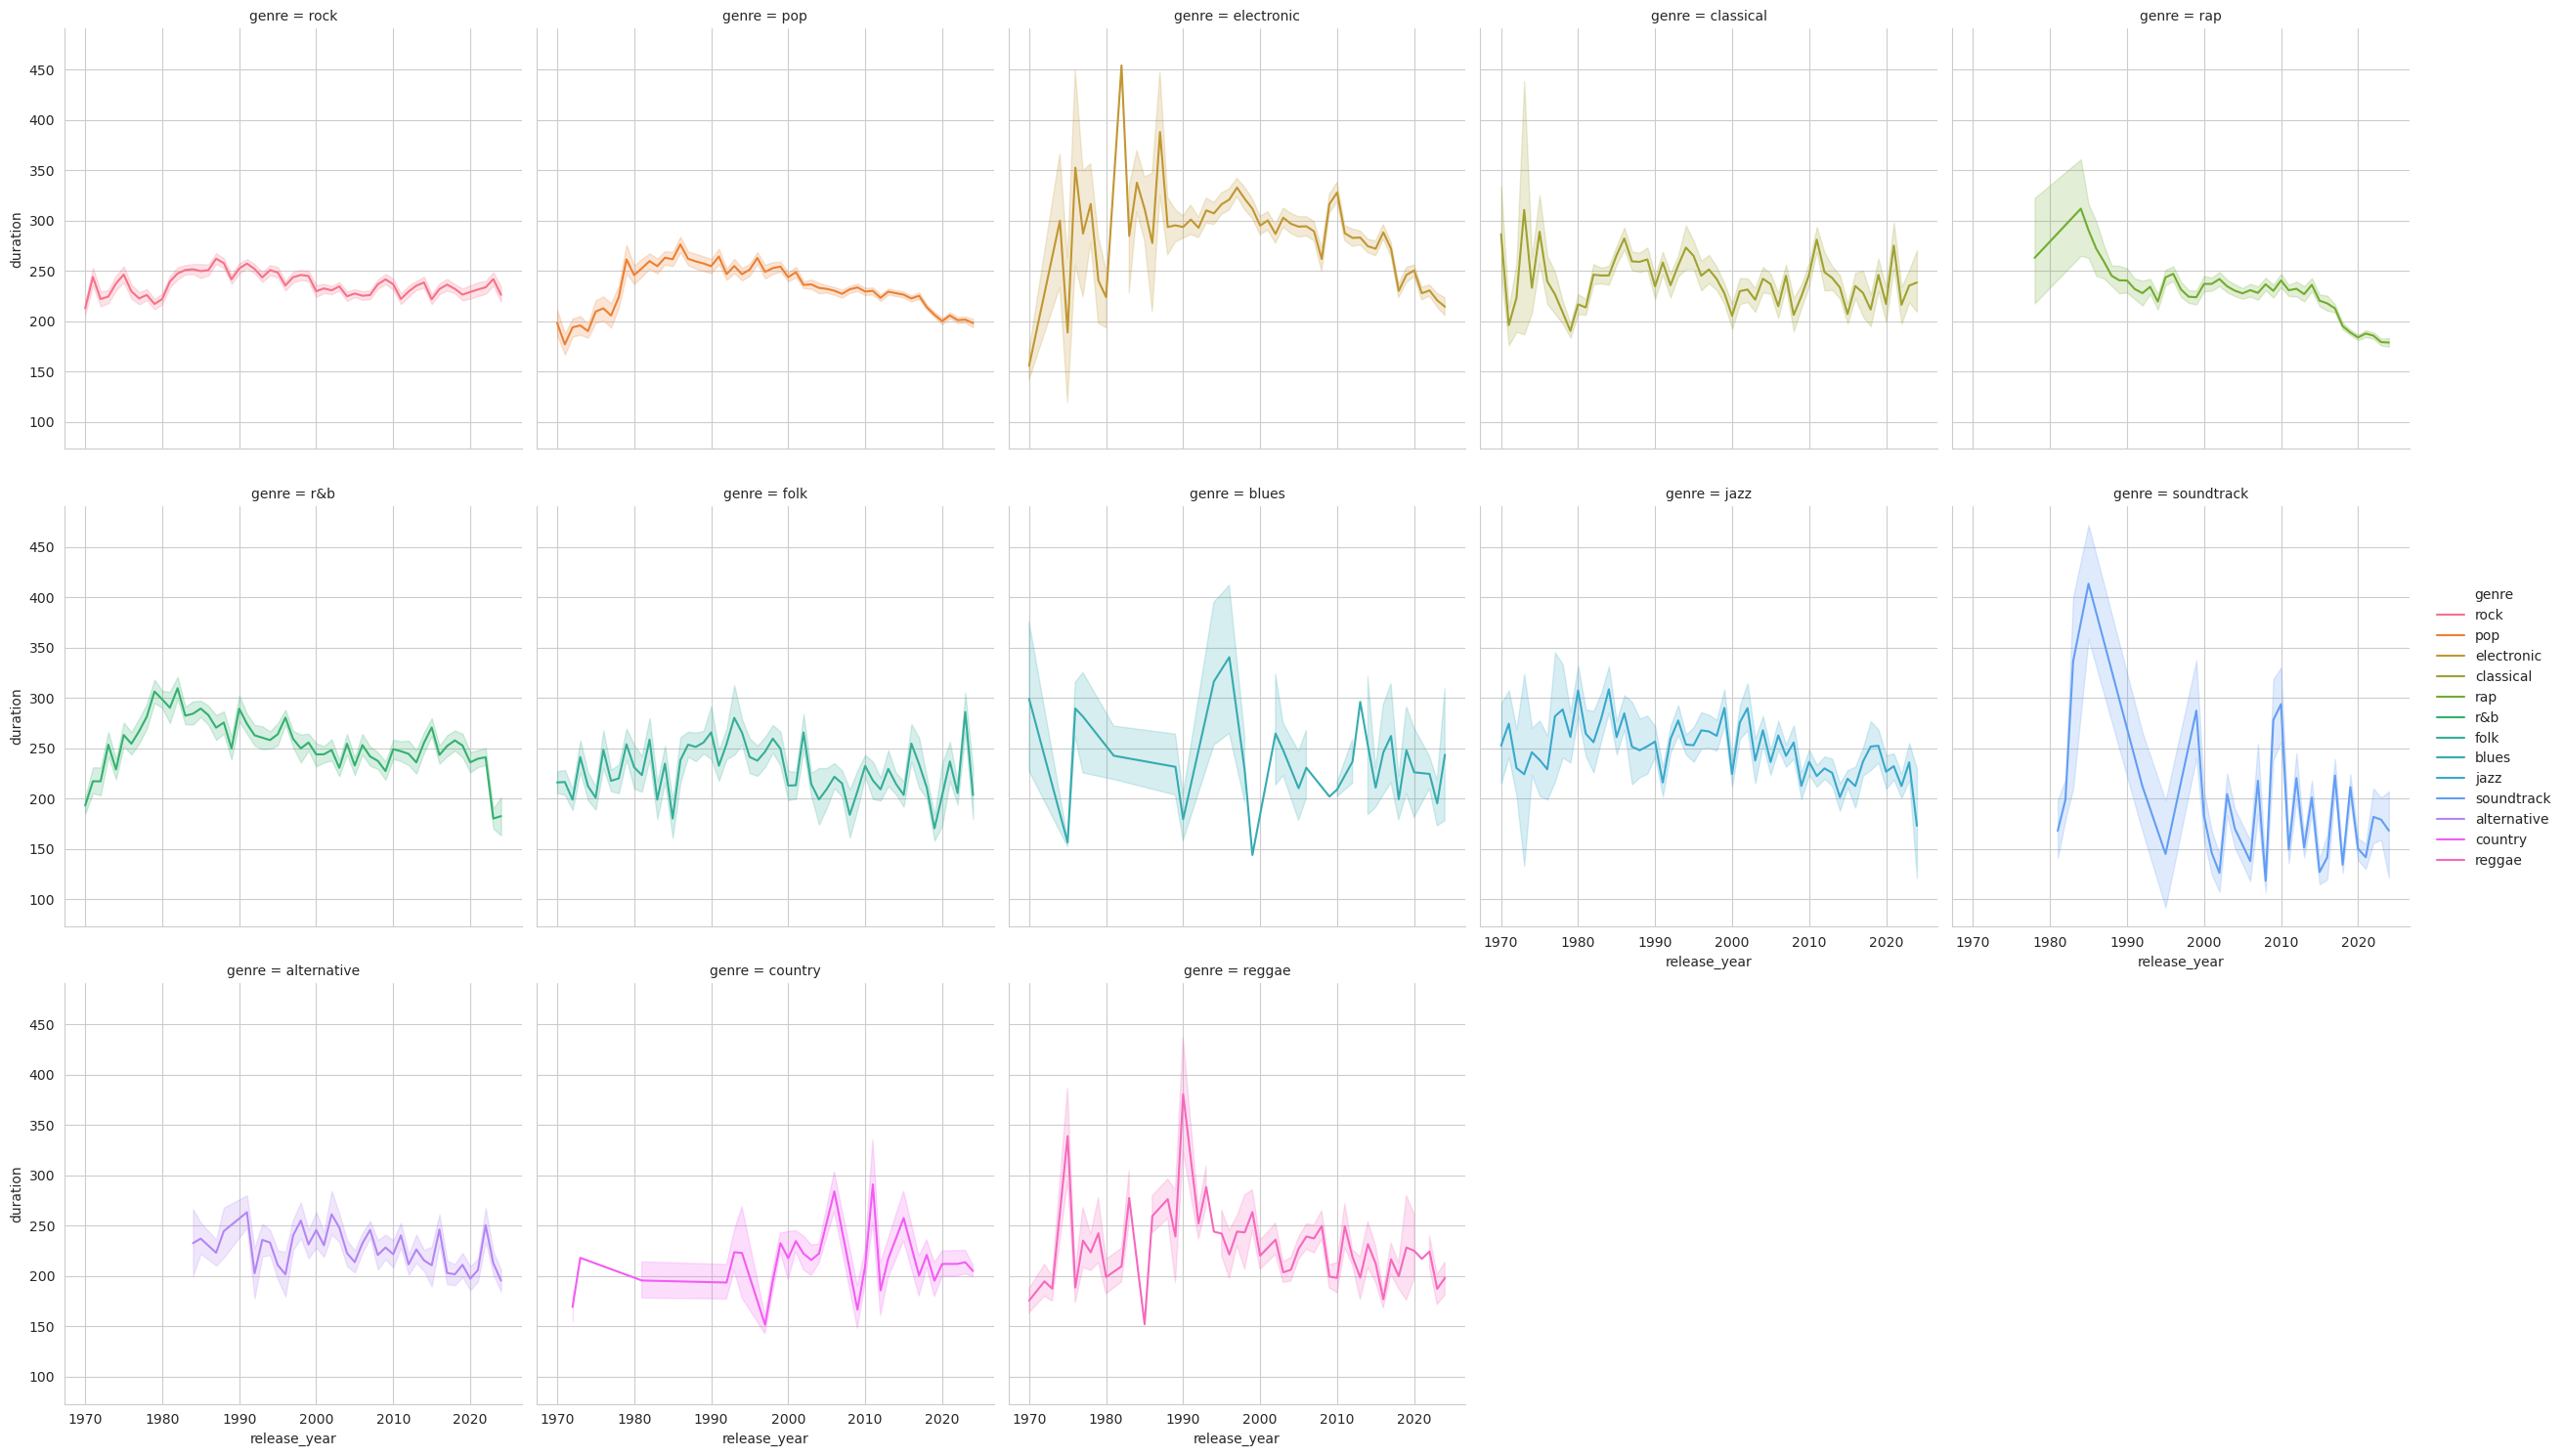

In [36]:
sns.relplot(data=df_1970[df_1970["duration"] < 600], x="release_year", y="duration", col="genre", col_wrap=5, hue="genre", kind="line")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# What about decreasing loudness?

It seems to be beneficial for our hearing systems.

---

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Let's also see some statistics across genres

**Folk, Classical music and Soundtracks** seem to be louder than other genres in general. <br>

However **Rock, Electronic and Alternative** varies more and have some records with extremely high loudness.

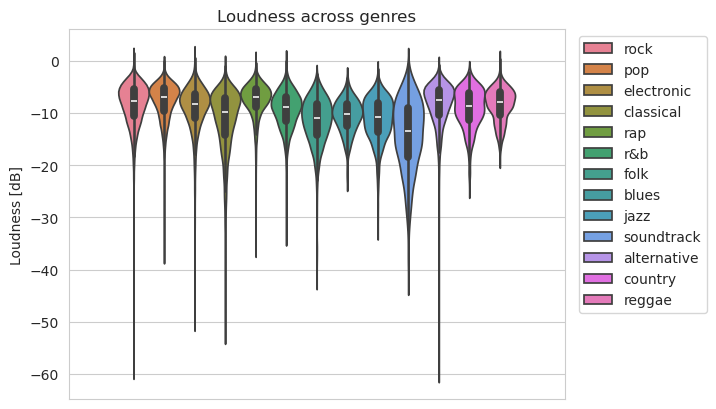

In [37]:
sns.violinplot(data=df_1970, y="loudness", hue="genre")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title("Loudness across genres")
plt.ylabel("Loudness [dB]")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Constant improvement - except of Classical music

Classical music is the only genre with **increasing** mean loudness with years. 

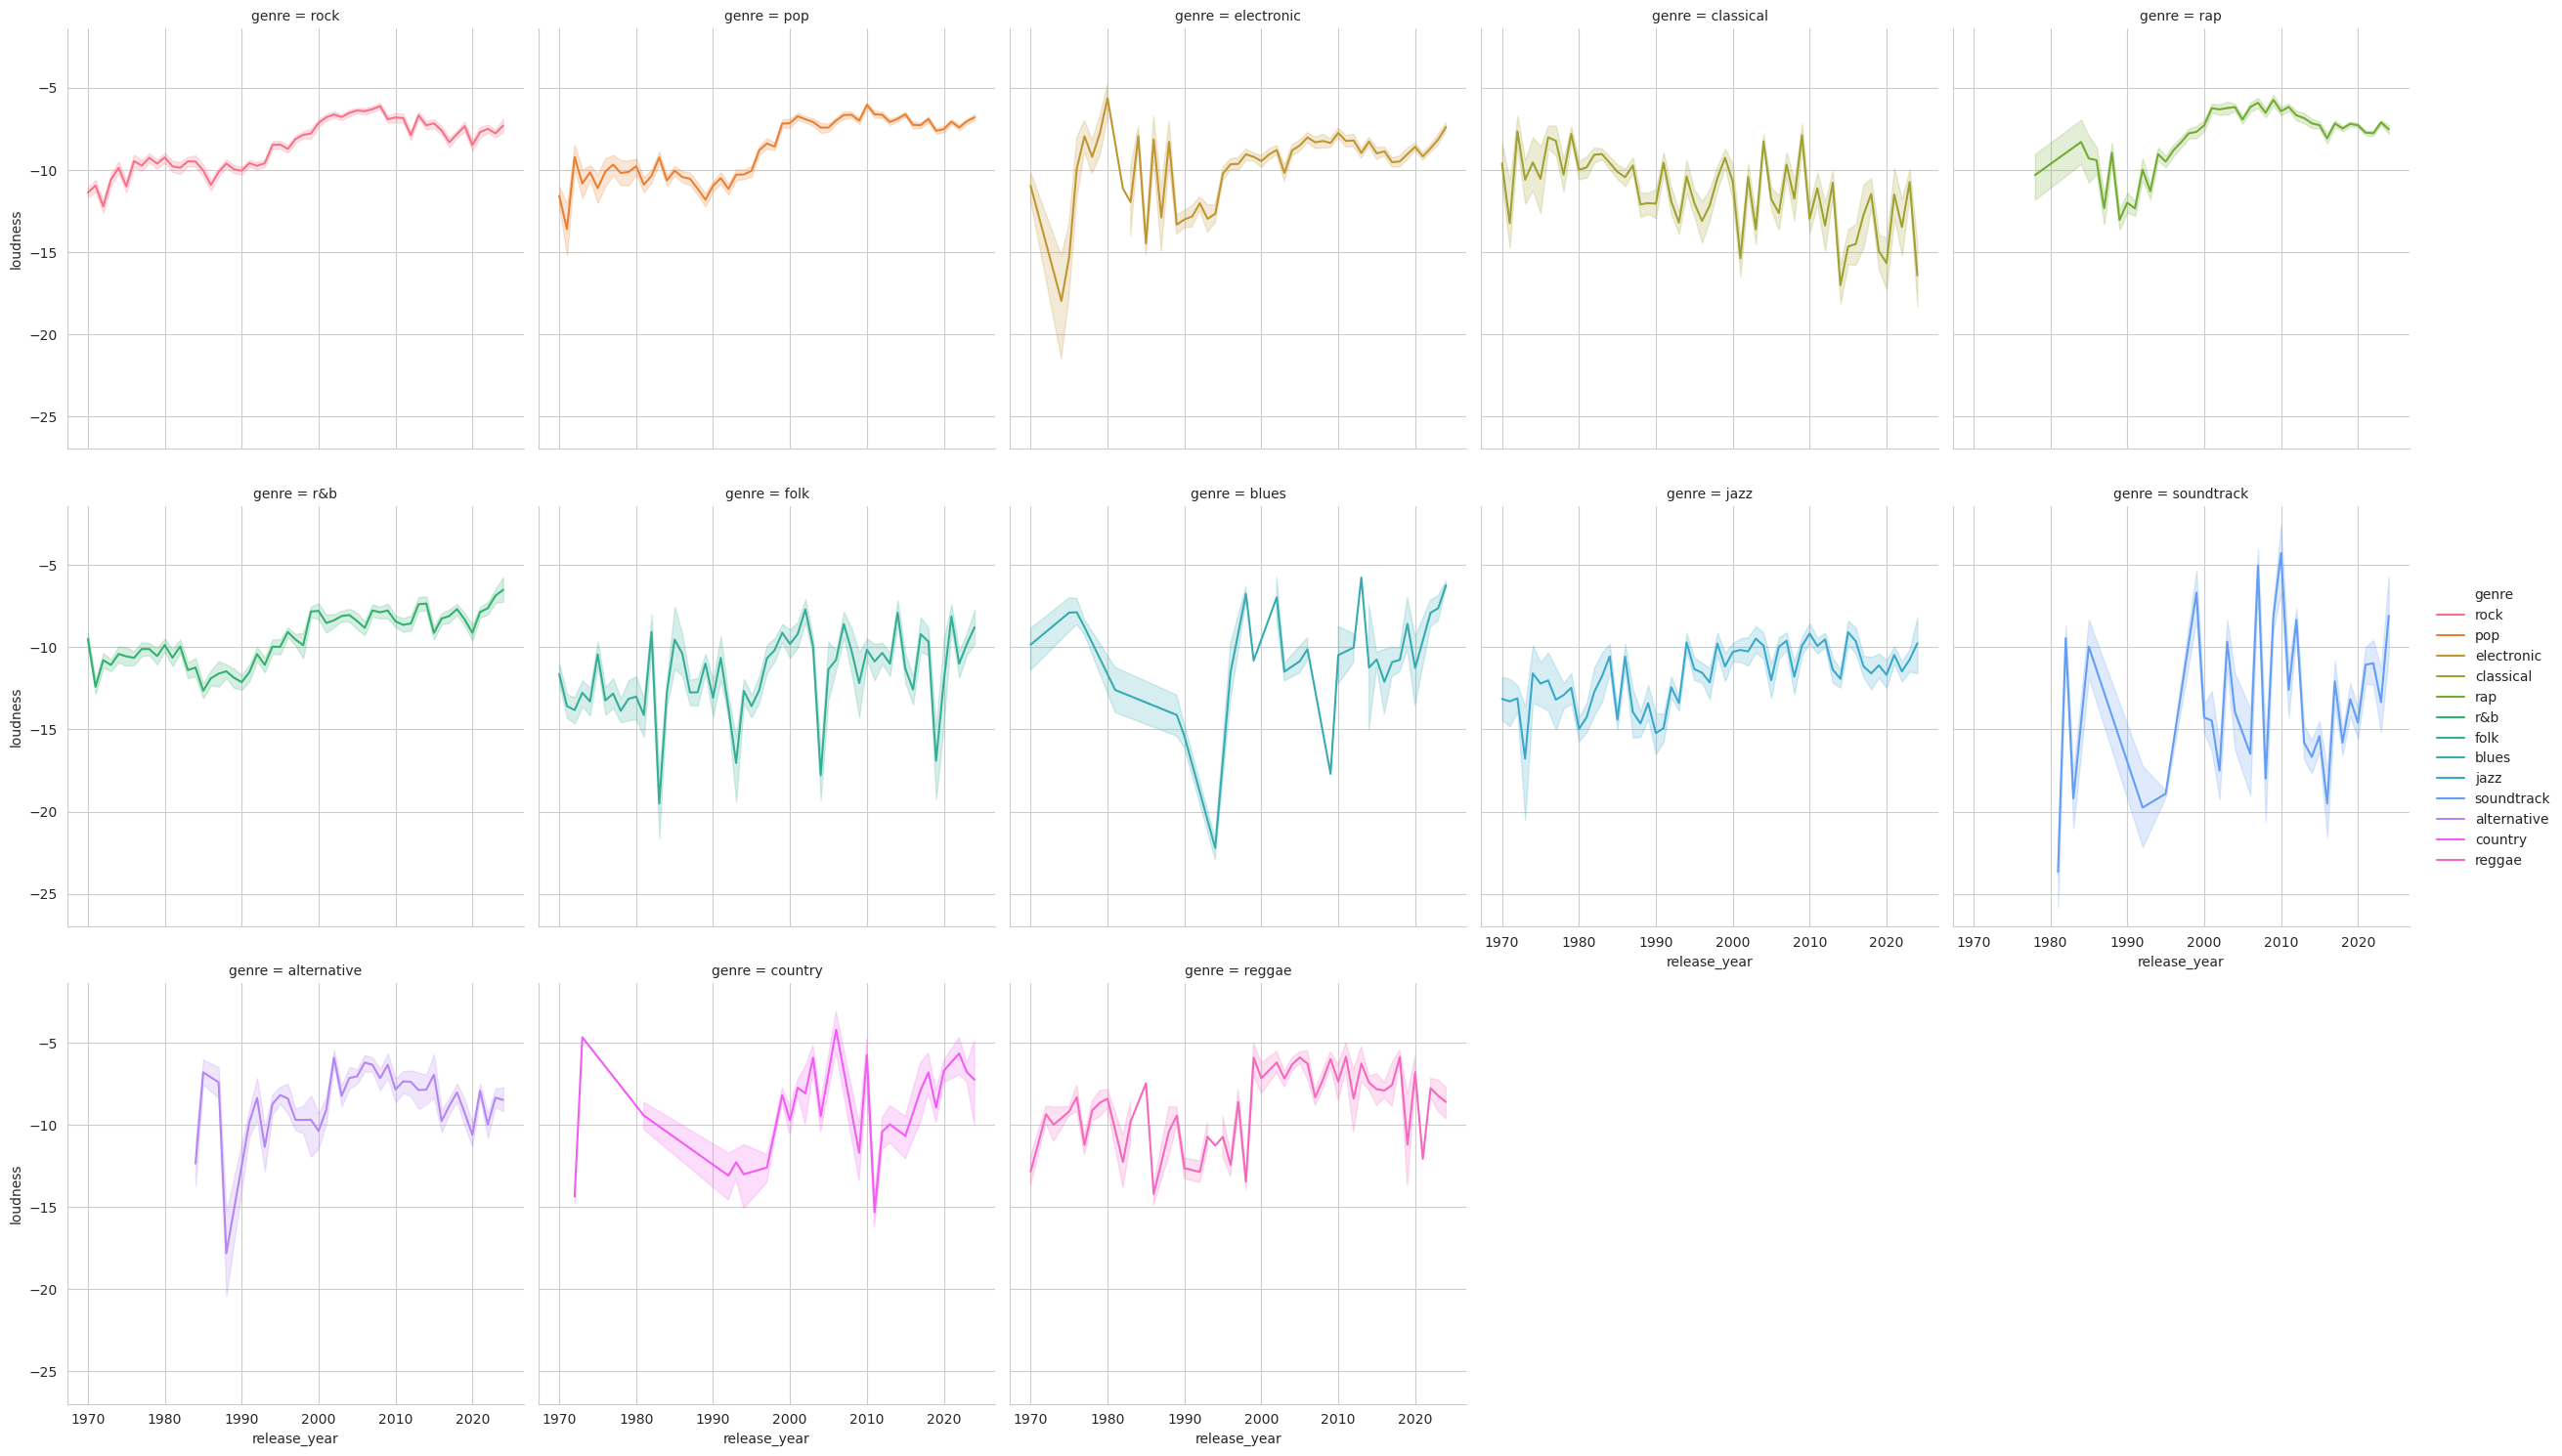

In [38]:
sns.relplot(data=df_1970, x="release_year", y="loudness", col="genre", col_wrap=5, hue="genre", kind="line")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# More and more negative sentiment

Valence seems to be decreasing with passing years. Let's see if we can find something interesting.

---

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Listen to Reggae and R&B!

These two genres with the highest mean valence are less likely to make you feel depressed. 

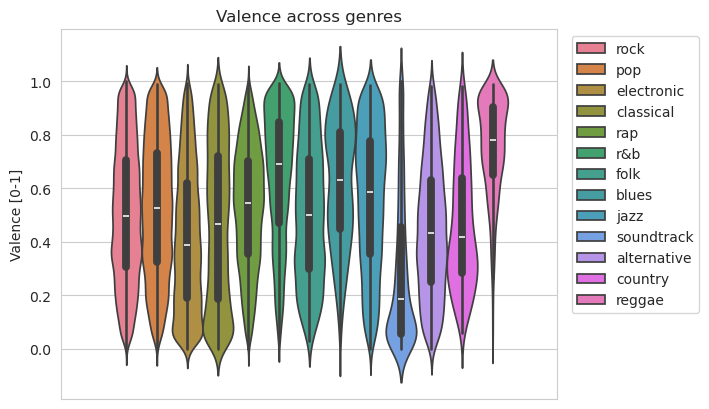

In [39]:
sns.violinplot(data=df_1970, y="valence", hue="genre")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title("Valence across genres")
plt.ylabel("Valence [0-1]")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Slight decreasing trend in every genre

**Rap, Electronic and Pop** are decreasing faster than the others.<br><br>
**R&B** even tough is on average a positive genre, with passing years the valence seems to be decreasing also in here!

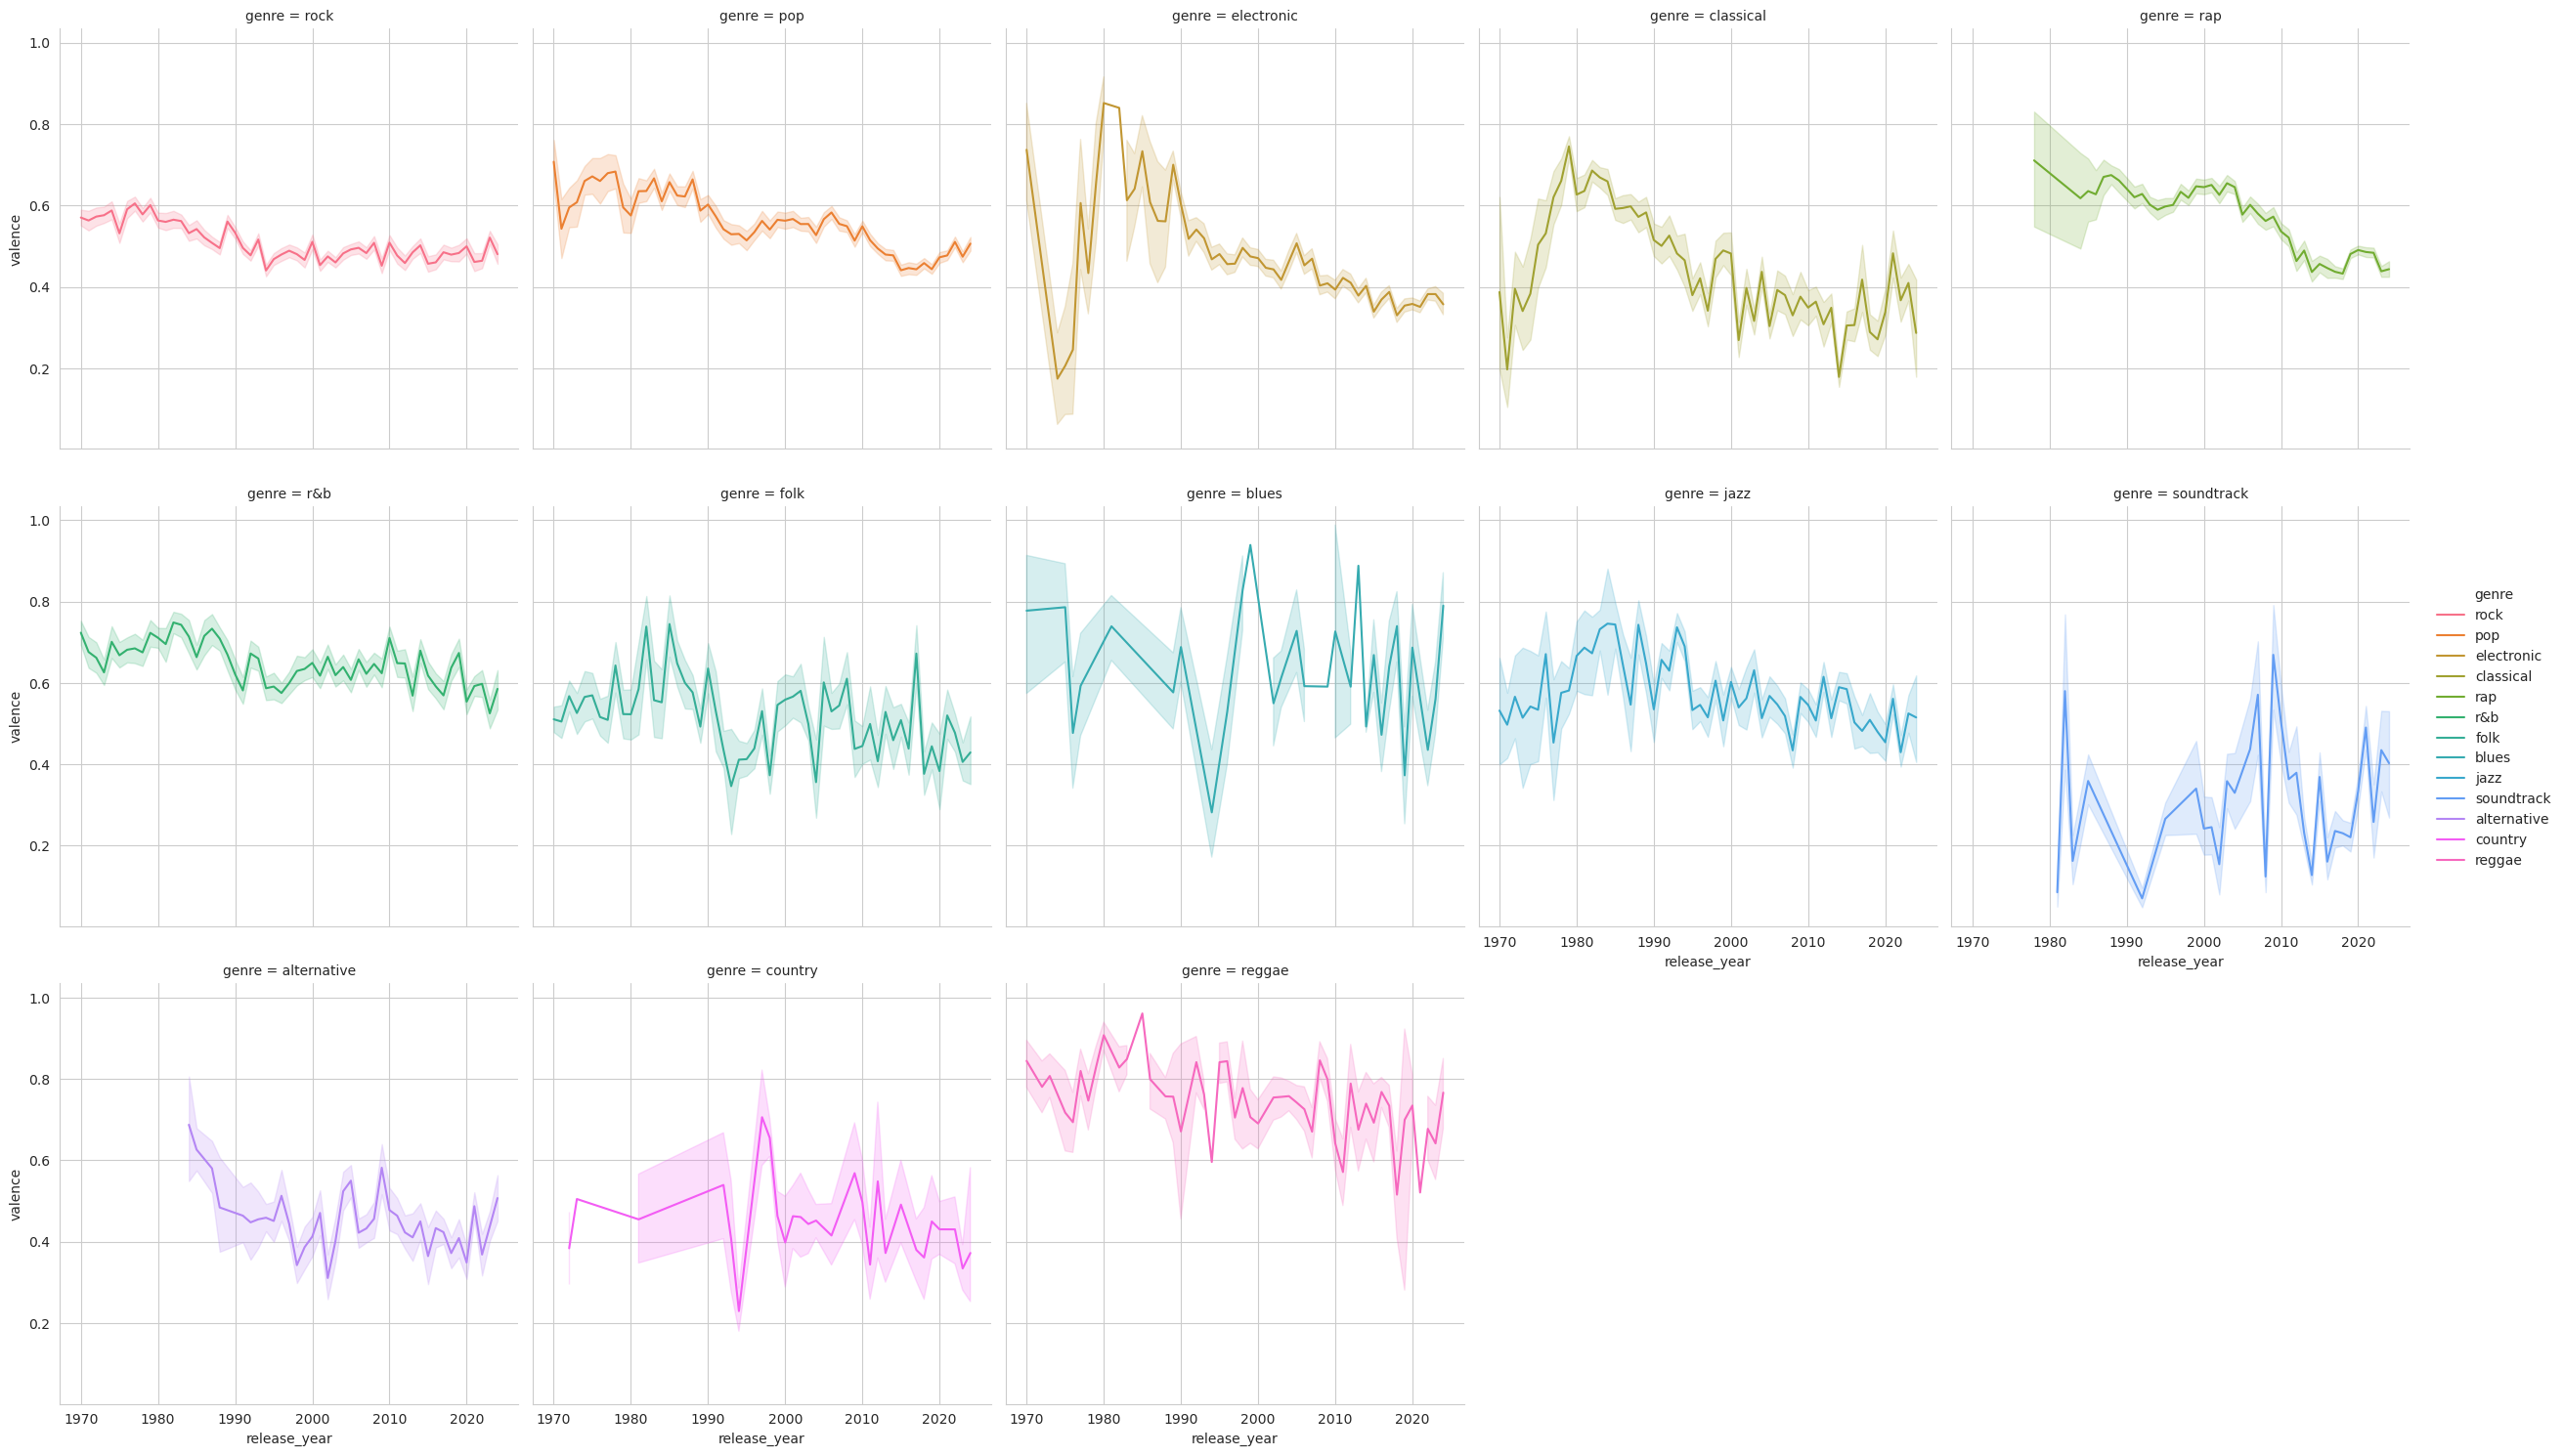

In [40]:
sns.relplot(data=df_1970, x="release_year", y="valence", col="genre", col_wrap=5, hue="genre", kind="line")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

## The majority of the songs are released on Friday

Monday and Tuesday are also favourite artists weekdays.

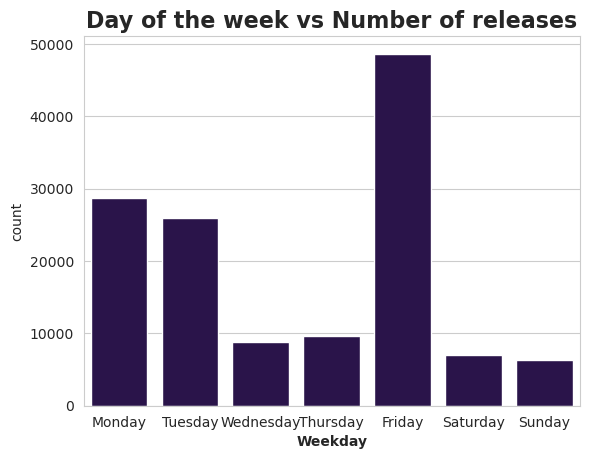

In [42]:
sns.countplot(data=df_1970, x="day_of_week", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Day of the week vs Number of releases", weight="bold", fontsize=16)
plt.xlabel("Weekday", weight="bold")
plt.savefig("figures/days_releases.png")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Preparation for the lyrics analysis

Further analysis and the classification problem is presented in **lyrics-analysis.jpynb**.

In [237]:
lyrics = no_duplicates[~no_duplicates["lyrics"].isna()]
lyrics = lyrics[lyrics["genre"].isin(["pop", "rap", "rock", "r&b", "alternative", "electronic"])]

lyrics.to_csv("lyrics_data.csv", index=False)


In [45]:
no_duplicates.drop(["lyrics"], axis=1).to_csv("bipower_data.csv", index=False)